# Setting Up Spark Session & Loading Data

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Retweet").getOrCreate()
df= spark.read.csv("../Downloads/Assignment-2/train.data", sep= '\t')
label= spark.read.csv("../Downloads/Assignment-2/train.solution", sep= '\t')
cols = spark.read.csv('./Assignment-2/feature.name', sep= '\t', header= True)
df = df.toDF(*cols.columns)
label = label.withColumnRenamed("_c0","label")

# Data Cleaning 

In [2]:
df.dtypes

[('tweet_id', 'string'),
 ('username', 'string'),
 ('timestamp', 'string'),
 ('#followers', 'string'),
 ('#friends', 'string'),
 ('#favorites', 'string'),
 ('entities', 'string'),
 ('sentiment', 'string'),
 ('mentions', 'string'),
 ('hashtags', 'string'),
 ('urls', 'string')]

In [3]:
#Changing data type
def convertColumn(df, names, newType):
  for name in names: 
     df = df.withColumn(name, df[name].cast(newType))
  return df

In [4]:
columns = ['#Followers', '#Friends', '#Favorites']
df = convertColumn(df, columns, 'double')
label = convertColumn(label, ['label'], 'double')

In [5]:
df.dtypes

[('tweet_id', 'string'),
 ('username', 'string'),
 ('timestamp', 'string'),
 ('#Followers', 'double'),
 ('#Friends', 'double'),
 ('#Favorites', 'double'),
 ('entities', 'string'),
 ('sentiment', 'string'),
 ('mentions', 'string'),
 ('hashtags', 'string'),
 ('urls', 'string')]

In [6]:
label.dtypes

[('label', 'double')]

In [7]:
from pyspark.sql.functions import monotonically_increasing_id

#Indexing both sets of data
df = df.withColumn("id", monotonically_increasing_id())
label = label.withColumn("id", monotonically_increasing_id())

#Joining data
df = df.join(label, "id", "inner").drop("id")

# Feature Engineering

In [8]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
from pyspark.sql import functions as F

#Not using convert column beccause it kept saying error syntax

#Counting mentions and changing data type
df = df.withColumn("mentions_count",F.when(F.col("Mentions")!='null;',F.size(F.split("Mentions"," "))).otherwise(0))
df = df.drop("Mentions")
df = df.withColumn("mentions_count", df["mentions_count"].cast(IntegerType()))
#Counting urls and changing data type
df = df.withColumn("url_count",F.when(F.col("URLs")!='null;',F.size(F.split("URLs",""":\-\:"""))-1).otherwise(0))
df = df.drop("URLs")
df = df.withColumn("url_count", df["url_count"].cast(IntegerType()))
#Counting hashtags and changing data type
df = df.withColumn("hash_count",F.when(F.col("Hashtags")!='null;',F.size(F.split("Hashtags"," "))).otherwise(0))
df = df.drop("Hashtags")
df = df.withColumn("hash_count", df["hash_count"].cast(IntegerType()))

In [9]:
#Splitting sentiment 
split = F.split(df['sentiment'], ' ')
df = df.withColumn('pos', split.getItem(0))
df = df.withColumn('neg', split.getItem(1))
df = df.drop("sentiment")

df = df.withColumn("pos", df["pos"].cast(IntegerType()))
df = df.withColumn("neg", df["neg"].cast(IntegerType()))

In [10]:
#Function to split entities and calculate average

def enti_score(row):
    lis = []
    for x in row:
        arr=x.split(sep=":")
        #print(arr[2])
        try:
            lis.append(float(arr[2]))
        except:
            continue
    if len(lis) == 0:
        return 0.0
    
    return sum(lis) / len(lis)

In [11]:
#UDF to create entity score
udf_e = F.udf(enti_score, 'double')
df = df.withColumn("enti_score",udf_e(F.split("entities","[;]")))
df = df.drop("entities")

In [12]:
df.dtypes

[('tweet_id', 'string'),
 ('username', 'string'),
 ('timestamp', 'string'),
 ('#Followers', 'double'),
 ('#Friends', 'double'),
 ('#Favorites', 'double'),
 ('label', 'double'),
 ('mentions_count', 'int'),
 ('url_count', 'int'),
 ('hash_count', 'int'),
 ('pos', 'int'),
 ('neg', 'int'),
 ('enti_score', 'double')]

In [13]:
df = df.drop("tweet_id","username")

In [14]:
df.schema

StructType(List(StructField(timestamp,StringType,true),StructField(#Followers,DoubleType,true),StructField(#Friends,DoubleType,true),StructField(#Favorites,DoubleType,true),StructField(label,DoubleType,true),StructField(mentions_count,IntegerType,false),StructField(url_count,IntegerType,false),StructField(hash_count,IntegerType,false),StructField(pos,IntegerType,true),StructField(neg,IntegerType,true),StructField(enti_score,DoubleType,true)))

In [15]:
#Formatting time stamp column
def GetDate(row):
    months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Agu','Sep','Oct','Nov','Dec']
    m_idx = months.index(row[1])
    mnum=m_idx+1
    date=row[2]+'-'+str(mnum)+'-'+row[5]+' '+row[3]
    return date

In [16]:
#UDF to convert time from string to timestamp format
udf_t = F.udf(GetDate, StringType())

df = df.withColumn("Date",udf_t(F.split("timestamp"," ")))
df = df.withColumn("Date",F.to_timestamp(F.col("Date"),"dd-M-yyyy HH:mm:ss"))
df = df.drop("timestamp")

In [17]:
#Getting day of the week as numbers: 1 to 7 / Monday to Sunday
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn("Day_of_week",F.date_format(F.col('Date'),'u'))
df = df.withColumn('Day_of_week', df['Day_of_week'].cast(IntegerType()))

In [18]:
df = df.drop("tweet_id","username","timestamp")

# Data Exploration

In [19]:
df_sum = df.select(["label","#Followers","#Friends","#Favorites","enti_score"])\
    .summary().show()

+-------+------------------+------------------+-----------------+------------------+-------------------+
|summary|             label|        #Followers|         #Friends|        #Favorites|         enti_score|
+-------+------------------+------------------+-----------------+------------------+-------------------+
|  count|           2408165|           2408165|          2408165|           2408165|            2408165|
|   mean|41.452324072478426|171518.46026165152|3040.640019683037|115.55898869055899|-1.3830168462339232|
| stddev| 582.3149157166315|1835699.1097671906| 18290.5202899602|1561.9270346592625| 1.0482440031142382|
|    min|               0.0|               0.0|              0.0|               0.0|-2.9999586123896154|
|    25%|               0.0|             185.0|            177.0|               0.0|  -2.26989562351054|
|    50%|               0.0|             941.0|            512.0|               0.0|  -1.70891033236613|
|    75%|               9.0|            6228.0|        

In [20]:
df_sum2 = df.select(["mentions_count","url_count","hash_count","pos","neg"])\
    .summary().show()

+-------+------------------+-------------------+------------------+------------------+------------------+
|summary|    mentions_count|          url_count|        hash_count|               pos|               neg|
+-------+------------------+-------------------+------------------+------------------+------------------+
|  count|           2408165|            2408165|           2408165|           2408165|           2408165|
|   mean|1.3858581118818685|0.23122418937240596|0.6186453170775258|1.6267913535824996|-1.624036143702778|
| stddev| 4.953336527567542| 0.4473869936975953| 1.722989384002213|0.7747132804262831|1.0072551035773385|
|    min|                 0|                  0|                 0|                 1|                -5|
|    25%|                 0|                  0|                 0|                 1|                -2|
|    50%|                 0|                  0|                 0|                 1|                -1|
|    75%|                 1|                  

In [22]:
#Very small sample because my macbook keeps crashing 
df_s = df.sample(False, 0.002, 67)

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np

#Creating correlation vector
vec = VectorAssembler(inputCols=df.drop("Date").columns, outputCol='vector_cor')
df_vec = vec.transform(df).select('vector_cor')
matrix = Correlation.corr(df_vec, 'vector_cor')

#Putting correlation matrix in a dataframe and printing it
rows = matrix.collect()[0][0].toArray().tolist()
np_array = np.array(rows)
np_array = np.array.tolist()
df_cor = spark.createDataFrame(np_array.tolist(),df.columns)
df_cor.show()

In [23]:
#Converting df to pandas as I am struggling to get the correlation matrix to work with pyspark
df_pandas = df_s.toPandas()

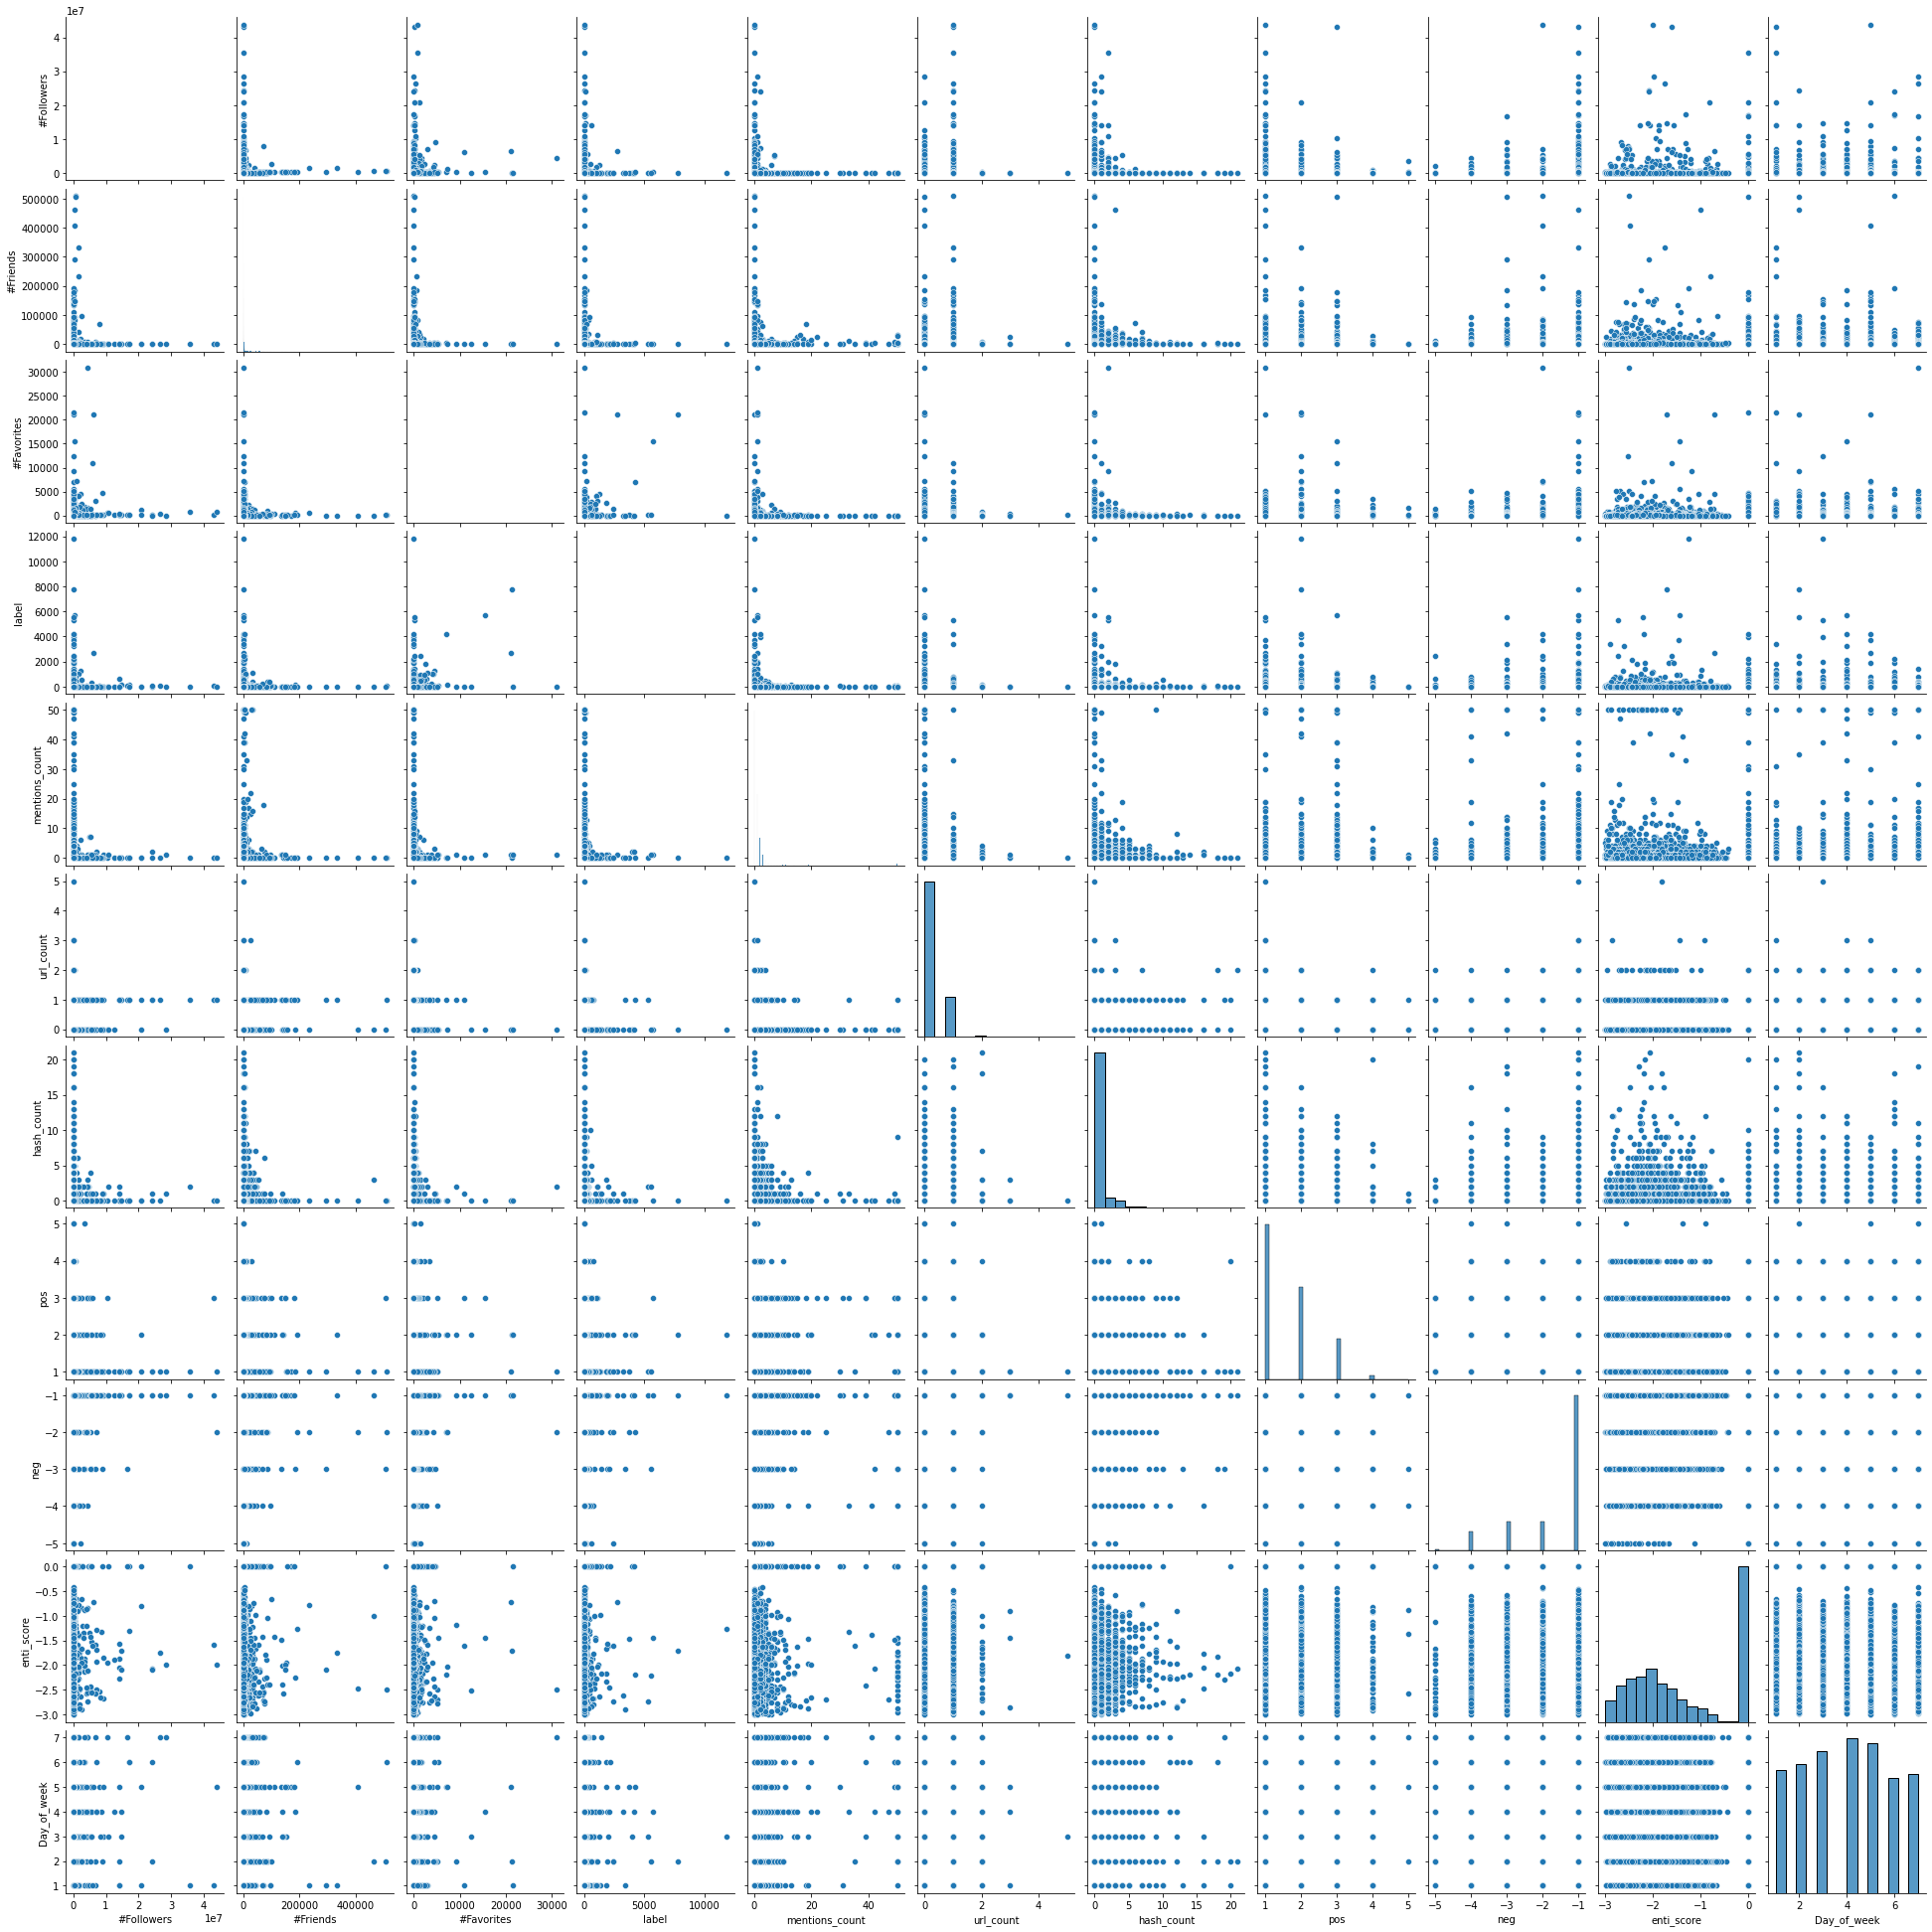

In [24]:
import seaborn as sns
sns.pairplot(df_pandas)

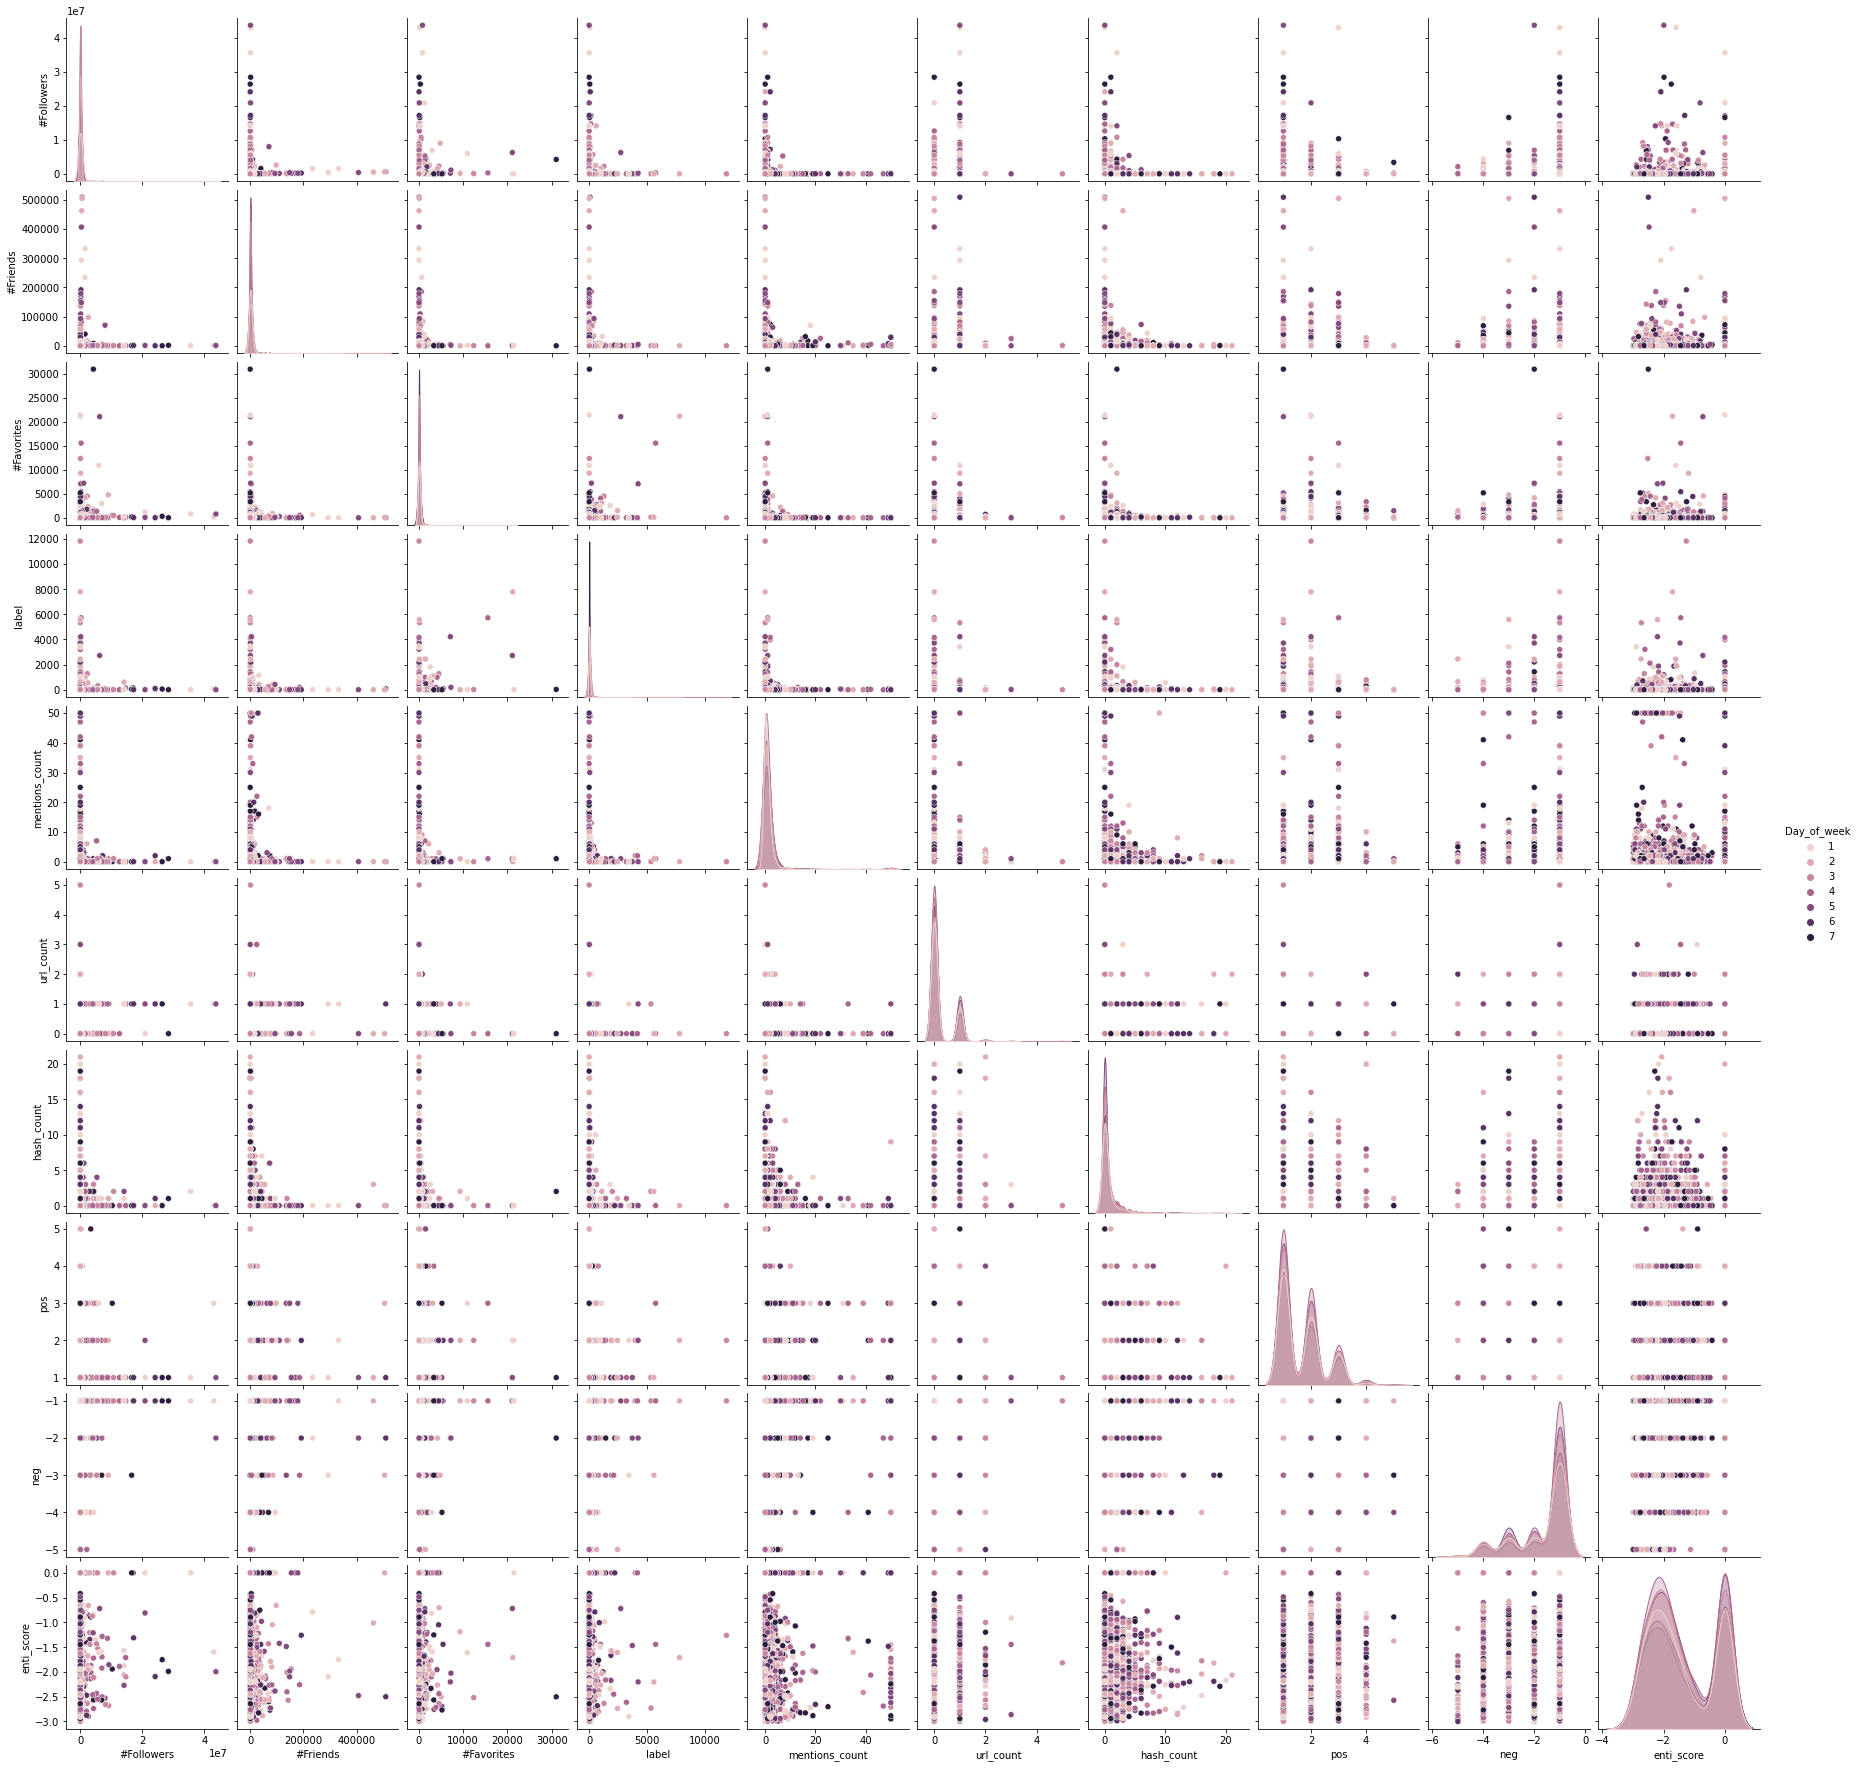

In [25]:
sns.pairplot(df_pandas, hue = "Day_of_week")

<AxesSubplot:>

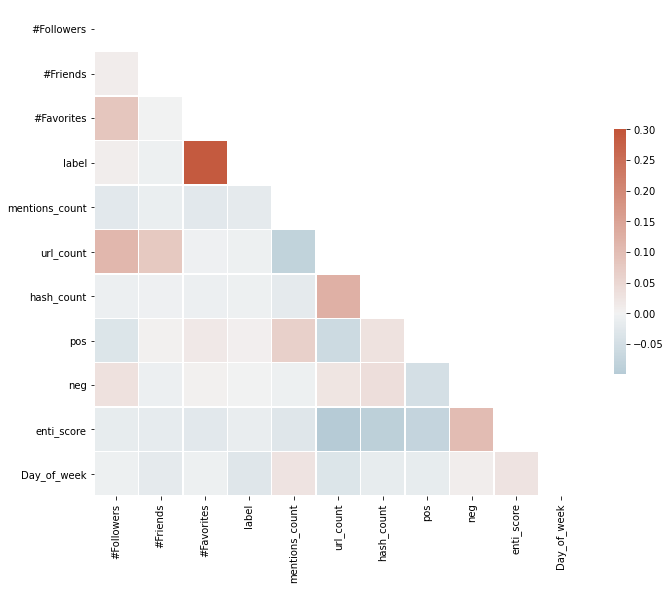

In [26]:
import numpy as np
import matplotlib.pyplot as plt
#Compute correlation matrix
corr = df_pandas.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [64]:
df_b.dtypes

[('#Followers', 'double'),
 ('#Friends', 'double'),
 ('#Favorites', 'double'),
 ('label', 'double'),
 ('mentions_count', 'int'),
 ('url_count', 'int'),
 ('hash_count', 'int'),
 ('pos', 'int'),
 ('neg', 'int'),
 ('enti_score', 'double'),
 ('Date', 'timestamp'),
 ('Day_of_week', 'int')]

In [27]:
#Bigger sample for the tests 
df_b = df
df = df.sample(False, 0.1, 67)

In [28]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

#Creating features vector
vec = VectorAssembler(inputCols=df.drop("label","Date").columns, outputCol='features')
df_vec = vec.transform(df)

#Creating scaled features vector and removing unscaled 
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaler = standardScaler.fit(df_vec)
df_f = scaler.transform(df_vec)

In [29]:
df_f.select("features").show(4)

+--------------------+
|            features|
+--------------------+
|[629.0,846.0,0.0,...|
|[762.0,1136.0,0.0...|
|[1123.0,1082.0,0....|
|[2888.0,1075.0,0....|
+--------------------+
only showing top 4 rows



# Linear Regression Unscaled

In [30]:
from pyspark.ml.regression import LinearRegression

train_uns, test_uns = df_vec.randomSplit([.8,.2],seed=67)
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_uns)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [5.804050458070843e-06,9.609127034847383e-05,0.026141054161944486,-0.0997979987056192,-0.7220315271769028,0.25656527151743275,2.9238178893123576,-2.2638429607565462,-0.760368923518574,-0.45736723394470247]
Intercept: 28.755153771521883


In [31]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 554.016725
r2: 0.007335


In [32]:
lr_predictions = lr_model.transform(test_uns)
lr_predictions.select("prediction","label","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
| 32.36991095732941| 52.0|(10,[5,6,7,9],[1....|
|34.077603772422954|  0.0|[0.0,28.0,2.0,1.0...|
| 43.97449865969008|  0.0|[0.0,30.0,0.0,1.0...|
|  37.8661802117892|  4.0|(10,[1,3,6,7,9],[...|
| 41.24967331750258| 22.0|[2.0,6.0,208.0,0....|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.0161913


In [33]:
test_result = lr_model.evaluate(test_uns)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 538.233


# Linear Regression Scaled Features

In [34]:
from pyspark.ml.regression import LinearRegression

train_df, test_df = df_f.randomSplit([.8,.2],seed=67)
lr = LinearRegression(featuresCol = 'features_scaled', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [10.29531056142982,1.8850960081665102,44.87167878814601,-0.501603338401288,-0.32171810849723176,0.4436105185879885,2.2643748383566473,-2.2785348990091228,-0.7964729099343285,-0.8943093168102361]
Intercept: 28.755153771523418


In [35]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 554.016725
r2: 0.007335


In [36]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","label","features_scaled").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----+--------------------+
|        prediction|label|     features_scaled|
+------------------+-----+--------------------+
| 32.36991095732952| 52.0|(10,[5,6,7,9],[0....|
| 34.07760377242288|  0.0|[0.0,0.0014272777...|
| 43.97449865968885|  0.0|[0.0,0.0015292261...|
|37.866180211789754|  4.0|(10,[1,3,6,7,9],[...|
|41.249673317502946| 22.0|[1.12751342923350...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.0161913


In [37]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 538.233


In [38]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 6
objectiveHistory: [0.49999999999999983, 0.4969850305012946, 0.4963835584465393, 0.4963832950963493, 0.4963832865239774, 0.4963832862515803, 0.4963832862458663]
+-------------------+
|          residuals|
+-------------------+
| -33.76237804918921|
|-31.714153690989686|
| -34.34512715770011|
| -36.44029728530794|
| -30.99019069013202|
|-31.564059937330168|
| -35.29450338085533|
|-25.360845865000076|
|-31.764135328673134|
|-33.824833781485296|
|-43.644206709123566|
|-27.612210485107763|
| -38.27829148409691|
| -35.19144875427335|
| 229.54269750290445|
|-7.1577222197889085|
|-42.967146242478925|
| -38.64518744935957|
| -32.96779795255253|
|-30.694615894920958|
+-------------------+
only showing top 20 rows



# Decision Tree Regression Unscaled

In [39]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')
dt_model = dt.fit(train_uns)
dt_predictions = dt_model.transform(test_uns)
dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 542.413


In [40]:
dt_model.featureImportances

SparseVector(10, {0: 0.7316, 1: 0.012, 2: 0.1075, 3: 0.0504, 5: 0.0478, 6: 0.005, 7: 0.0108, 8: 0.013, 9: 0.022})

# Decision Tree Regression Scaled

In [41]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features_scaled', labelCol = 'label')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 542.413


In [42]:
y_true = dt_predictions.select("label").toPandas()
y_pred = dt_predictions.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

r2_score: 0.0008523893682812478


In [43]:
dt_model.featureImportances

SparseVector(10, {0: 0.7316, 1: 0.012, 2: 0.1075, 3: 0.0504, 5: 0.0478, 6: 0.005, 7: 0.0108, 8: 0.013, 9: 0.022})

# Gradient Boost Tree Regression Unscaled 

In [44]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10)
gbt_model = gbt.fit(train_uns)
gbt_predictions = gbt_model.transform(test_uns)
gbt_predictions.select('prediction', 'label', 'features').show(5)

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
| 27.15511026391475| 52.0|(10,[5,6,7,9],[1....|
| 26.35631094156747|  0.0|[0.0,28.0,2.0,1.0...|
| 24.73360083721249|  0.0|[0.0,30.0,0.0,1.0...|
|21.814909587984808|  4.0|(10,[1,3,6,7,9],[...|
| 44.34396235096325| 22.0|[2.0,6.0,208.0,0....|
+------------------+-----+--------------------+
only showing top 5 rows



In [45]:
gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 545.323


# Gradient Boost Tree Regression Scaled

In [46]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features_scaled', labelCol = 'label', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'label', 'features').show(5)

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
| 27.15511026391475| 52.0|(10,[5,6,7,9],[1....|
| 26.35631094156747|  0.0|[0.0,28.0,2.0,1.0...|
| 24.73360083721249|  0.0|[0.0,30.0,0.0,1.0...|
|21.814909587984808|  4.0|(10,[1,3,6,7,9],[...|
| 44.34396235096325| 22.0|[2.0,6.0,208.0,0....|
+------------------+-----+--------------------+
only showing top 5 rows



In [47]:
gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 545.323


In [48]:
y_true = gbt_predictions.select("label").toPandas()
y_pred = gbt_predictions.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

r2_score: -0.00989605006118599


# Experimentation: Removing null values

In [49]:
df = df_b.na.drop("all")

In [50]:
print("Shape of the data: ", df.count(), ",", len(df.columns))

Shape of the data:  2408165 , 12


In [51]:
df.schema

StructType(List(StructField(#Followers,DoubleType,true),StructField(#Friends,DoubleType,true),StructField(#Favorites,DoubleType,true),StructField(label,DoubleType,true),StructField(mentions_count,IntegerType,false),StructField(url_count,IntegerType,false),StructField(hash_count,IntegerType,false),StructField(pos,IntegerType,true),StructField(neg,IntegerType,true),StructField(enti_score,DoubleType,true),StructField(Date,TimestampType,true),StructField(Day_of_week,IntegerType,true)))

In [52]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

#Creating features vector
vec = VectorAssembler(inputCols=df.drop("label","Date").columns, outputCol='features')
df_vec = vec.transform(df)

#Creating scaled features vector and removing unscaled 
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaler = standardScaler.fit(df_vec)
df_f = scaler.transform(df_vec)

## Linear Regression

In [53]:
from pyspark.ml.regression import LinearRegression

train_df, test_df = df_f.randomSplit([.8,.2],seed=67)
lr = LinearRegression(featuresCol = 'features_scaled', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [6.521408903436377,2.558785684904726,54.99720396844355,-0.27418280272138934,0.4205234696173279,0.5924130712666358,0.11558218030011554,-0.9032584709294502,-0.6160361328843493,0.0]
Intercept: 33.37417744616478


In [54]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 562.896853
r2: 0.010024


In [55]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","label","features_scaled").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----+--------------------+
|        prediction|label|     features_scaled|
+------------------+-----+--------------------+
| 34.71851036395487|  0.0|(10,[6,7,9],[3.87...|
|34.913145496334366|  0.0|(10,[5,6,7,9],[0....|
|36.446020675153434|  0.0|(10,[4,6,7,8,9],[...|
| 36.62654153865029|  0.0|(10,[4,6,7,8,9],[...|
| 36.01749341565316|  0.0|(10,[3,6,7,8,9],[...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.0230208


In [56]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 637.009


In [57]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 6
objectiveHistory: [0.5, 0.4962617825230293, 0.4950395384748171, 0.49503919587489414, 0.4950391898592597, 0.49503918973235184, 0.4950391897307189]
+-------------------+
|          residuals|
+-------------------+
| -35.95517066324495|
|-34.569316871058355|
| -34.71851036395487|
| -36.22890190708544|
| -34.76395200343785|
|-37.581609538597704|
|  -40.4941839689436|
|-36.745808145771086|
| -36.37696229629911|
| -35.53573433561583|
|-35.362933188173216|
| -35.46219904972633|
|-37.480226981918946|
|-35.612691105993086|
| -37.49581924307924|
| -32.42012337816184|
|-19.532628130377425|
| 107.57987662183817|
|  767.1081941720015|
| -35.45306682590491|
+-------------------+
only showing top 20 rows



## Decision Tree Regression 

In [58]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features_scaled', labelCol = 'label')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 643.658


In [59]:
y_true = dt_predictions.select("label").toPandas()
y_pred = dt_predictions.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

r2_score: 0.002519671108771271


In [60]:
dt_model.featureImportances

SparseVector(10, {0: 0.0752, 1: 0.1573, 2: 0.6171, 4: 0.0284, 5: 0.1003, 7: 0.0163, 8: 0.0045, 9: 0.0009})

## Gradient Boost Tree

In [61]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features_scaled', labelCol = 'label', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'label', 'features').show(5)

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|34.164344235250915|  0.0|(10,[6,7,9],[3.0,...|
| 33.32767530412397|  0.0|(10,[5,6,7,9],[1....|
|31.811693422981936|  0.0|(10,[4,6,7,8,9],[...|
| 36.22767988241046|  0.0|(10,[4,6,7,8,9],[...|
| 30.52113401351323|  0.0|(10,[3,6,7,8,9],[...|
+------------------+-----+--------------------+
only showing top 5 rows



In [62]:
gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 643.689


In [63]:
y_true = gbt_predictions.select("label").toPandas()
y_pred = gbt_predictions.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

r2_score: 0.0024225379906398503


# Experimentation: Dropping labels with 0 as value

In [38]:
df = df_b.filter(df.label != 0) 

In [39]:
df = df.na.drop("all")

In [40]:
print("Shape of the data: ", df.count(), ",", len(df.columns))

Shape of the data:  2134859 , 12


In [41]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

#Creating features vector
vec = VectorAssembler(inputCols=df.drop("label","Date").columns, outputCol='features')
df_vec = vec.transform(df)

#Creating scaled features vector and removing unscaled 
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaler = standardScaler.fit(df_vec)
df_f = scaler.transform(df_vec)

In [42]:
from pyspark.ml.regression import LinearRegression

train_df, test_df = df_f.randomSplit([.8,.2],seed=67)
lr = LinearRegression(featuresCol = 'features_scaled', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.5737501344526866,0.0,-0.2209264671023788,-0.26517001370460236,0.4630168723498417,0.0,0.12247404313327702,0.0,0.4464067290262937,0.8974956681267047]
Intercept: 84.11702743963828


In [43]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 841.315268
r2: 0.000004


In [44]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","label","features_scaled").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+-----+--------------------+
|       prediction|label|     features_scaled|
+-----------------+-----+--------------------+
|85.80555549494177|  1.0|(10,[5,6,7,9],[0....|
|86.60334787190217|  2.0|(10,[6,7,8,9],[1....|
|84.80111369519948|  2.0|(10,[6,7,8,9],[2....|
|84.58577399879688|  2.0|(10,[5,6,7,8,9],[...|
|85.89150877083812| 37.0|(10,[3,6,7,9],[0....|
+-----------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = -1.95644e-06


In [45]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 920.484


In [46]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 4
objectiveHistory: [0.5, 0.4999995495811438, 0.4999988538747228, 0.49999885351226075, 0.49999885350899215]
+------------------+
|         residuals|
+------------------+
|-85.10504440786055|
|-84.04856540579478|
|-84.76195056064577|
|-84.43337836319093|
| -84.2432099972201|
|-84.10504440786055|
|-85.36126487816271|
| -85.0224842755554|
|-83.80488362234732|
|-84.20633538571748|
|-77.83046332936335|
|-79.47754793654518|
|-57.05368710469787|
|-55.57933904106599|
| 6.973561286029579|
| 72.21669158204533|
|  335.493933417977|
|-84.66560596619814|
|-82.24859424687739|
|-8.890553142485345|
+------------------+
only showing top 20 rows

